#### Импорт библиотек

In [176]:
import pandas as pd
import torch
from pathlib import Path
from torch.utils.data.dataset import Dataset
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from PIL import Image
from PIL import Image, ImageDraw, ImageFont
import glob
import datetime
from math import sqrt

from time import time

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import IPython.display as ipd

from tqdm.notebook import tqdm
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

import sklearn
clear_output()

#### SSD



In [177]:
from torch.nn.modules.pooling import AdaptiveAvgPool2d
class AuxiliaryConvolutionLayers(nn.Module):
  def __init__(self, in_channels=1024):
    super().__init__()
    self.conv_block8= nn.Sequential(
        nn.Conv2d(in_channels, 256, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(256, 512, kernel_size= 3, stride= 2, padding= 1),
        nn.ReLU()
    )

    self.conv_block9= nn.Sequential(
        nn.Conv2d(512, 128, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding= 1),
        nn.ReLU()
    )

    self.conv_block10= nn.Sequential(
        nn.Conv2d(256, 128, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size= 3, stride= 1, padding= 0),
        nn.ReLU()
    )

    self.conv_block11= nn.Sequential(
        nn.Conv2d(256, 128, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding= 0),
        nn.ReLU()
    )

  def forward(self, x):
      x= self.conv_block8(x)
      output8= x
      x= self.conv_block9(x)
      output9= x
      x= self.conv_block10(x)
      output10= x
      x= self.conv_block11(x)
      output11= x
      return output8, output9, output10, output11

In [178]:
class PredictionConvolutions(nn.Module):
  def __init__(self, n_classes= 2):
    super().__init__()
    num_boxes = {'conv4_3': 4,
               'conv7': 6,
               'conv8_2': 6,
               'conv9_2': 6,
               'conv10_2': 4,
               'conv11_2': 4}
    self.n_classes= n_classes
    # box coordinates predicting
    self.coordinates_output4_3= nn.Conv2d(512, 4*num_boxes['conv4_3'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output7= nn.Conv2d(1024, 4*num_boxes['conv7'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output8= nn.Conv2d(512, 4*num_boxes['conv8_2'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output9= nn.Conv2d(256, 4*num_boxes['conv9_2'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output10= nn.Conv2d(256, 4*num_boxes['conv10_2'], kernel_size= 3, stride= 1, padding= 1)
    self.coordinates_output11= nn.Conv2d(256, 4*num_boxes['conv11_2'], kernel_size= 3, stride= 1, padding= 1)

    # class predicting for each box
    self.class_output4_3= nn.Conv2d(512, n_classes*num_boxes['conv4_3'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output7= nn.Conv2d(1024, n_classes*num_boxes['conv7'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output8= nn.Conv2d(512, n_classes*num_boxes['conv8_2'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output9= nn.Conv2d(256, n_classes*num_boxes['conv9_2'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output10= nn.Conv2d(256, n_classes*num_boxes['conv10_2'], kernel_size= 3, stride= 1, padding= 1)
    self.class_output11= nn.Conv2d(256, n_classes*num_boxes['conv11_2'], kernel_size= 3, stride= 1, padding= 1)

  def forward(self, output4_3, output7, output8, output9, output10, output11):
    batch_size= output4_3.shape[0]
    #[B, 4*nb, x, y] -> [B, x, y, 4*nb] -> [B, x*y*nb, 4]
    cr_output4_3= self.coordinates_output4_3(output4_3).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)   
    cr_output7= self.coordinates_output7(output7).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output8= self.coordinates_output8(output8).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output9= self.coordinates_output9(output9).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output10= self.coordinates_output10(output10).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)
    cr_output11= self.coordinates_output11(output11).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4)

    #[B, num_cl*nb, x, y] -> [B, x, y, num_cl*nb] -> [B, x*y*nb, num_cl]
    cl_output4_3= self.class_output4_3(output4_3).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output7= self.class_output7(output7).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output8= self.class_output8(output8).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output9= self.class_output9(output9).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output10= self.class_output10(output10).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes) 
    cl_output11= self.class_output11(output11).permute(0, 2, 3, 1).contiguous().view(batch_size, -1, self.n_classes)

    # [B, total bx count, 4]
    local= torch.cat((cr_output4_3, cr_output7, cr_output8, cr_output9, cr_output10, cr_output11), dim= 1) 
    # [B, total bx count, num_classes]
    classes_scores= torch.cat((cl_output4_3, cl_output7, cl_output8, cl_output9, cl_output10, cl_output11), dim= 1) 

    return local, classes_scores

In [179]:
from torchvision.models import vgg16, VGG16_Weights
from torchvision.models.feature_extraction import create_feature_extractor

In [180]:
class Backbone(nn.Module):
  def __init__(self):
    super().__init__()
    nodes = {'features.29':'features.29', 'features.22':'features.22'}
    self.vgg_based = create_feature_extractor(vgg16(weights= VGG16_Weights.IMAGENET1K_V1), return_nodes=nodes).eval()
    for param in self.vgg_based.parameters():
      param.requires_grad = False
    
    self.BatchNorm= nn.Sequential(
        nn.AdaptiveAvgPool2d((38, 38)),
        nn.BatchNorm2d(512),
    )
        
    
    self.conv6_7= nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size= 3, stride=1, dilation= 6, padding= 6),
        nn.ReLU(),

        nn.Conv2d(1024, 1024, kernel_size= 1, stride= 1),
        nn.ReLU(),
        nn.AdaptiveAvgPool2d((19, 19))
    )

  def forward(self, x):
    output= self.vgg_based(x)
    output4_3= self.BatchNorm(output['features.22'])
    output7= self.conv6_7(output['features.29'])
    return output4_3, output7

In [181]:
class SSD(nn.Module):
  def __init__(self, n_classes= 2):
    super().__init__()
    self.n_classes= n_classes

    self.backbone = Backbone() # image size must be more than (300, 300)
    self.auxiliary_conv_layers= AuxiliaryConvolutionLayers(in_channels= 1024)
    self.box_class_predict= PredictionConvolutions(n_classes= n_classes)
    self.priors_cxcy = self.create_prior_boxes()
  
  def forward(self, image):
    output4_3, output7= self.backbone(image) # output4_3 ->[B, 512, 38, 38]; output7 -> [B, 1024, 19, 19]
    output8, output9, output10, output11= self.auxiliary_conv_layers(output7)
    local, classes_scores= self.box_class_predict(output4_3, output7, output8, output9, output10, output11)

    return local, classes_scores # [B, num_boxes, 4], [B, num_boxes, num_classes]

  
  def create_prior_boxes(self):
        fmap_dims = {'conv4_3': 38,
                     'conv7': 19,
                     'conv8': 10,
                     'conv9': 5,
                     'conv10': 3,
                     'conv11': 1}

        obj_scales = {'conv4_3': 0.1,
                      'conv7': 0.2,
                      'conv8': 0.375,
                      'conv9': 0.55,
                      'conv10': 0.725,
                      'conv11': 0.9}

        # Слова обычно преобладают протяженных боксами, по-этому сделаем сделаем следующеее соотношение сторон
        aspect_ratios = {'conv4_3': [1., .2, .08],
                         'conv7': [1., .2, .125, .1, .06],
                         'conv8': [1.,  .3, .2, .125, .06],
                         'conv9': [1., .3, .2, .125, .06],
                         'conv10': [1., .2, .1],
                         'conv11': [1.,  .2, .1]}

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append([cx, cy, obj_scales[fmap] * sqrt(ratio), obj_scales[fmap] / sqrt(ratio)])

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.:
                            try:
                                additional_scale = sqrt(obj_scales[fmap] * obj_scales[fmaps[k + 1]])
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.
                            prior_boxes.append([cx, cy, additional_scale, additional_scale])

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

  def detect_objects(self, predicted_locs, predicted_scores, min_score, max_overlap, top_k):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.
        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.
        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy))  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = class_scores > min_score  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[score_above_min_score]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[score_above_min_score]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(dim=0, descending=True)  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(class_decoded_locs, class_decoded_locs)  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(device)  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(torch.LongTensor((1 - suppress).sum().item() * [c]).to(device))
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0., 0., 1., 1.]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return all_images_boxes, all_images_labels, all_images_scores  # lists of length batch_size

In [182]:
def find_intersection(set_1, set_2):
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

def find_jaccard_overlap(set_1, set_2):
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union  # (n1, n2)

def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    return torch.cat([gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
                      torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:]], 1)  # w, h

def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    return torch.cat([(cxcy[:, :2] - priors_cxcy[:, :2]) / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
                      torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5], 1)  # g_w, g_h

def cxcy_to_xy(cxcy):
    return torch.cat([cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
                      cxcy[:, :2] + (cxcy[:, 2:] / 2)], 1)  # x_max, y_max

def xy_to_cxcy(xy):
    return torch.cat([(xy[:, 2:] + xy[:, :2]) / 2,  # c_x, c_y
                      xy[:, 2:] - xy[:, :2]], 1)  # w, h

#### LSTM

In [183]:
class ConvBlock(nn.Module):
  def __init__(self):
    super().__init__()
    self.block= nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 16, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),

        nn.Conv2d(in_channels= 16, out_channels= 32, kernel_size= 3, stride= 1, padding= 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2),  # 16, 64

        nn.Conv2d(in_channels= 32, out_channels= 64, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 64),
        nn.ReLU(),

        nn.Conv2d(in_channels= 64, out_channels= 128, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2, stride= 2), # 8, 32

        nn.Conv2d(in_channels= 128, out_channels= 256, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 256),
        nn.ReLU(),

        nn.Conv2d(in_channels= 256, out_channels= 512, kernel_size= 3, stride= 1, padding= 1),
        nn.BatchNorm2d(num_features= 512),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2,1), stride= (2,1)), # 4, 32

        nn.Conv2d(in_channels= 512, out_channels= 512, kernel_size= 2, stride=1) # 3, 31
    )
  
  def forward(self, x): # [B, 1, 32, 128]
    return self.block(x)

In [184]:
class TextRecognitionModel(nn.Module):
  def __init__(self, num_classes, hidden_size= 256, num_layers= 2): #
    super().__init__()

    self.conv_block= ConvBlock() 
    self.adaptive_flatt= nn.Sequential(
        nn.AdaptiveAvgPool2d(output_size= (1, None)),
        nn.Flatten(start_dim=2, end_dim=- 1)
    )

    self.recurent_layer= nn.LSTM(input_size= 512, hidden_size= hidden_size, num_layers= num_layers, bidirectional= True, batch_first= True, dropout= 0.2)
    self.classify_block= nn.Sequential(
        nn.Linear(in_features= 2*hidden_size , out_features= hidden_size),
        nn.ReLU(), 
        nn.Dropout(p= 0.5),

        nn.Linear(in_features= hidden_size , out_features= num_classes),
        nn.LogSoftmax(dim=2)
    )
  

  def forward(self, x): # x -> [B, 1, 32, 128]
    x= self.conv_block(x) # x -> [B, 512, 3, 31]
    x= self.adaptive_flatt(x) # x -> [B, 512, 31]
    x= torch.permute(x, (0, 2, 1)) #  x -> [B, 31, 512]
    x, (h0, c0)= self.recurent_layer(x) # x -> [B, 31, 2*hidden_size]
    x= torch.permute(x, (1, 0, 2)) # [31, B, 2*hidden_size]
    x= self.classify_block(x) # x -> [31, B, num_classes]
    return x

#### Предсказания

In [185]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'
DIR= Path('/content/gdrive/MyDrive/data/Russian pasport OCR/DataForOCR')
if not DIR.exists():
  drive.mount('/content/gdrive/')

passport_data= sorted(list(DIR.rglob('**/*')))
len(passport_data) 
alphabet= '^ ,-.:"АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя0123456789'
alphabet_dct= {}
for idx, item in enumerate(alphabet):
  alphabet_dct[item]= idx

In [186]:
def take_image(data):
  tf_ssd= tt.Compose([
      tt.ToTensor(),
      tt.Resize((300,300)),
      tt.ConvertImageDtype(torch.float)
  ])

  tf= tt.Compose([
      tt.ToTensor(),
      tt.ConvertImageDtype(torch.float)
  ])
  image_data= []
  image_data_ssd= []
  for image in data:
    image_data.append(tf(Image.open(image)))
    image_data_ssd.append(tf_ssd(Image.open(image)))
  return image_data_ssd, image_data

In [187]:
image_data_ssd, image_data= take_image(passport_data)

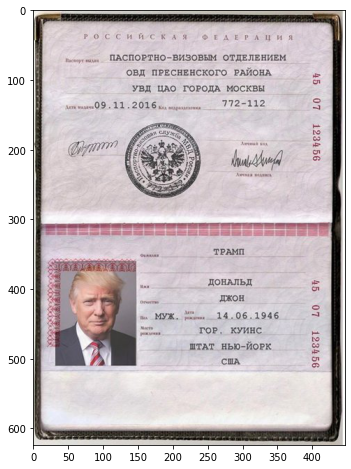

In [188]:
fig, ax= plt.subplots(figsize=(10,8))
ax.imshow(image_data[0].permute(1,2,0))
plt.show()

In [189]:
x1, x2, x3 =np.array([1,2,3])

In [250]:
model_LSTM= TextRecognitionModel(num_classes= len(alphabet), hidden_size= 256, num_layers= 2).to(device)
model_LSTM.load_state_dict(torch.load('/content/gdrive/MyDrive/data/Russian pasport OCR/weights/LSTM30.pt'))
model_LSTM.eval()

model_SSD= SSD(n_classes= 2).to(device)
model_SSD.load_state_dict(torch.load('/content/gdrive/MyDrive/data/Russian pasport OCR/weights/SSD30.pt'))
model_SSD.eval()
clear_output()

In [204]:
def drow_boxes(image, coordinates):
  image= image.to('cpu')
  coordinates= coordinates.to('cpu')
  fig, ax= plt.subplots(figsize= (12,10))
  ax.imshow(image.permute(1,2,0).to('cpu'))
  x_size, y_size= image.shape[2], image.shape[1]

  for box in coordinates:
    x1, x2, x3= np.array([box[0], box[2]]), np.array([box[0], box[0]]), np.array([box[2], box[2]])
    y1, y2, y3= np.array([box[1], box[3]]), np.array([box[1], box[1]]), np.array([box[3], box[3]])
    x1, x2, x3= np.array([x1, x2, x3])*x_size
    y1, y2, y3= np.array([y1, y2, y3])*y_size

    ax.plot(x1, y2,marker = 'o', color='red')
    ax.plot(x1, y3, marker= 'o', color='red')
    ax.plot(x2, y1, marker= 'o', color='red')
    ax.plot(x3, y1, marker= 'o', color='red')
  plt.show()

In [196]:
boxes= []
image_size= []
with torch.no_grad():
  for image in image_data_ssd:
    image= image.to(device) #[3, H, W]
    image_size.append((image.shape[2], image.shape[1]))
    predicted_locs, predicted_scores = model_SSD(image[None,:,:,:])
    det_boxes_batch, _, _ = model_SSD.detect_objects(predicted_locs, predicted_scores,
                                                                              min_score=0.2, max_overlap=0.2,
                                                                              top_k=100)
    image_size.append((image.shape[2], image.shape[1])) # (length, hight)
    boxes.append(det_boxes_batch[0])
  
  

Боксы, честно говоря, работают не лучшим образом. Основная ошибка, на мой вгляд,- использование неподходящего датасета для обучения SSD. В качестве данных обучения выходили одиночные слова на картинках, стоило сделать более разнообразный датасет, добавить многострочные предложения и слова. При этом многое зависит от гиперпараметров, можно, например, сделать малый min_score, тогда все будет в боксах. При большем max_overlap боксы будут сильно пересекаться, что затруднит классификацию слов в LSTM.

#### Примеры боксов

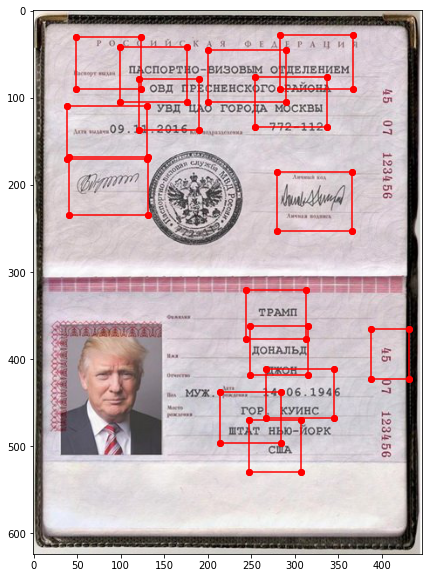

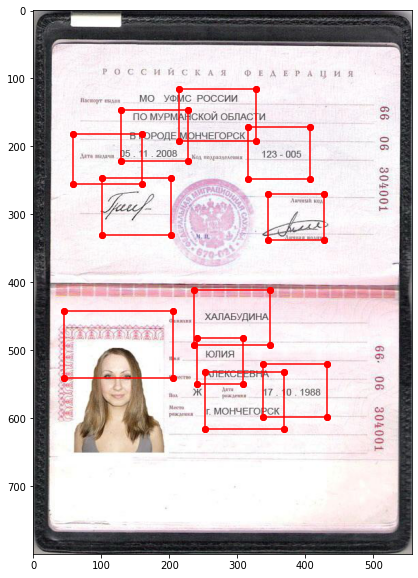

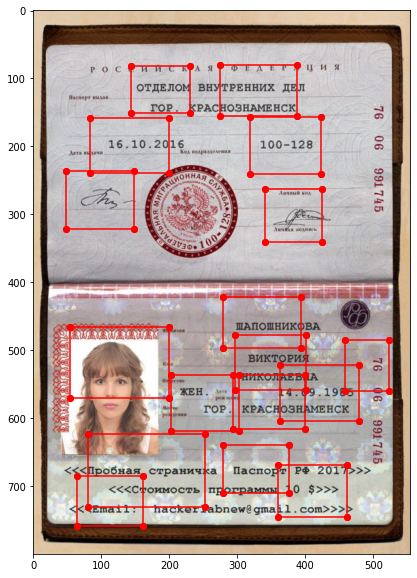

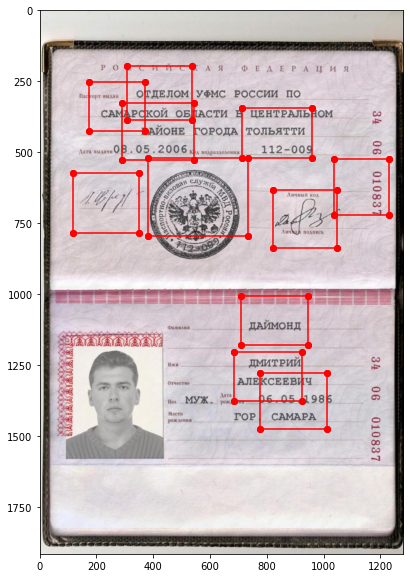

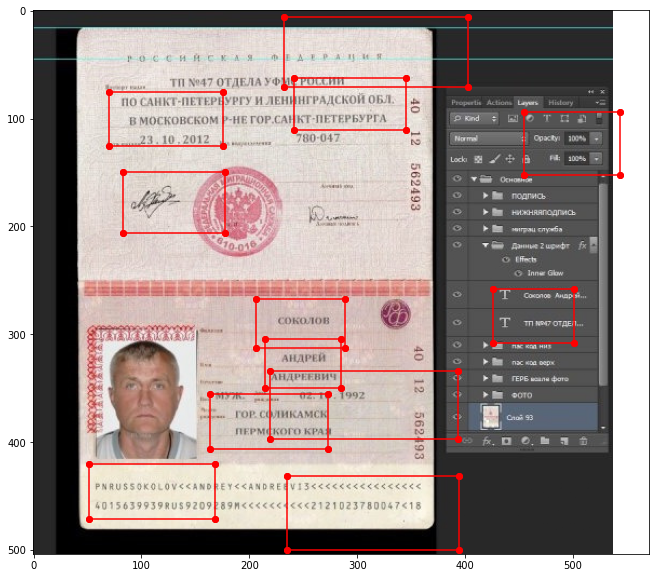

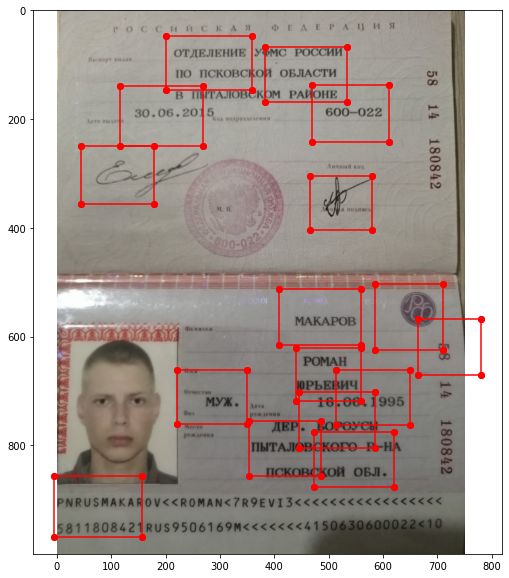

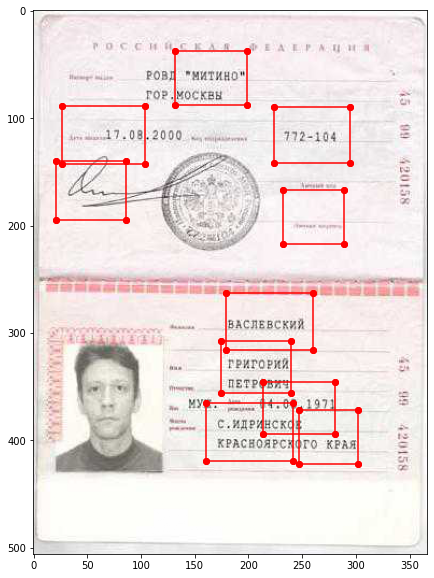

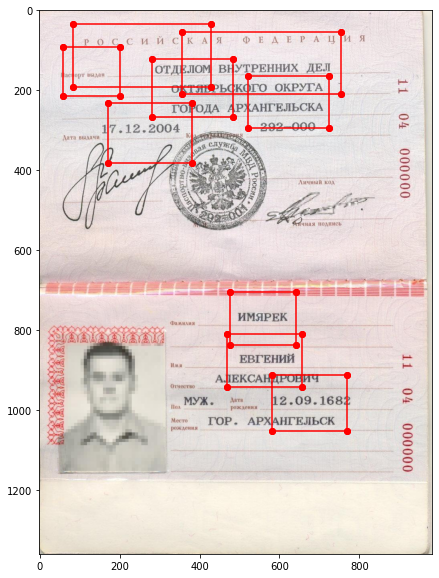

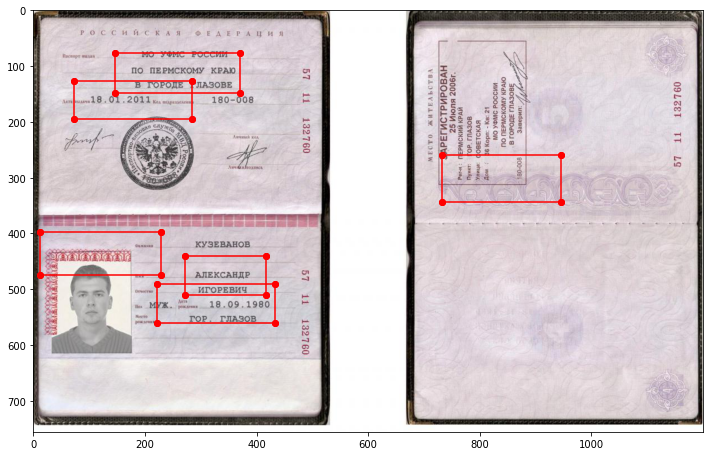

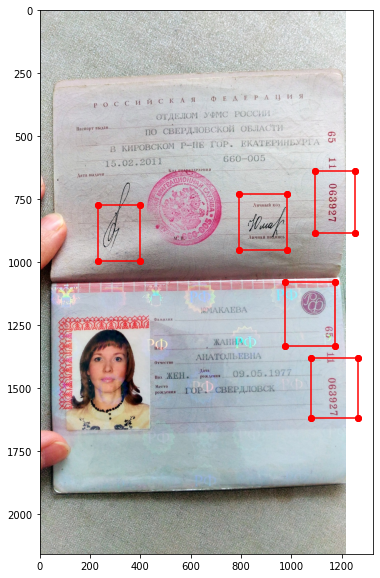

In [205]:
for i in range(len(image_data)):
 drow_boxes(image_data[i], boxes[i])

#### 1

In [267]:
def predict_to_text(predict):
  sentence= []
  for letter in predict:
    if letter!= 0:
      sentence.append(alphabet[letter])
  return ''.join(sentence)

def crop(image, box, resize= False):
  tf= tt.Resize((32, 128))
  box[0], box[1], box[2], box[3]= max(0, box[0]), max(0, box[1]), min(1, box[2]), min(1, box[3])
  x_size, y_size= image.shape[2], image.shape[1]
  x_start, x_end= int(box[0]*x_size), int(box[2]*x_size)
  y_start, y_end= int(box[1]*y_size), int(box[3]*y_size)
  image= image[:,y_start:y_end,x_start:x_end]
  if resize:
    image= tf(image)
  return torch.sum(image, dim= 0)/3
  
  


1


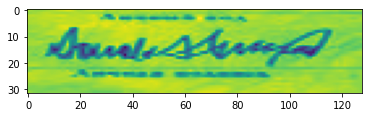

1


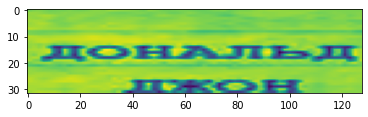

1


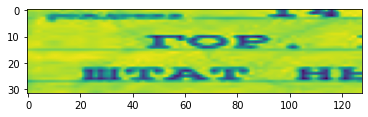

1


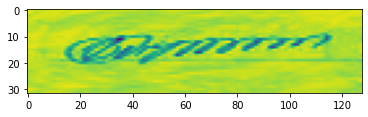

2,


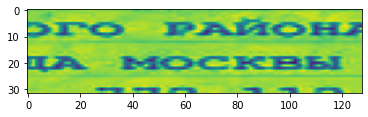

1


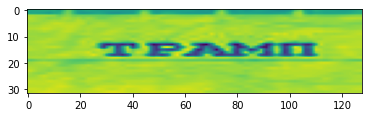

1


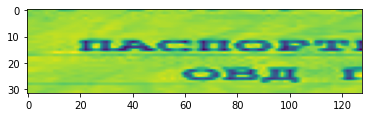

1


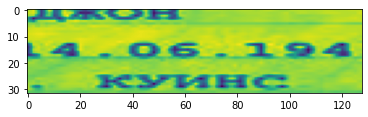

1


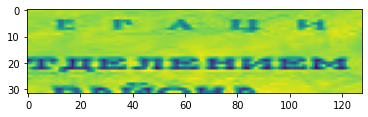

1,


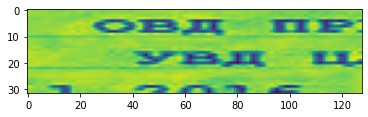

2


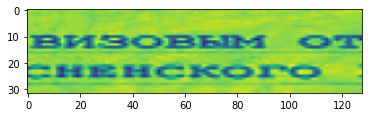

1.


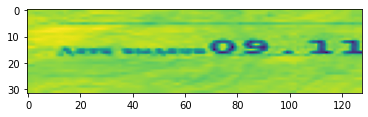

1,


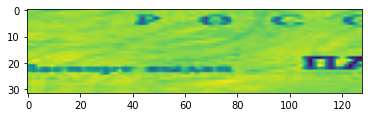

1,


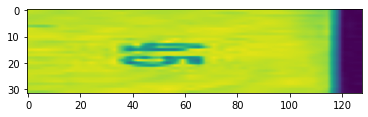

1,


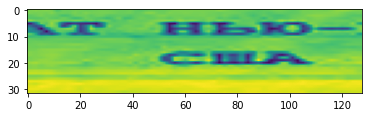

In [270]:
with torch.no_grad():
  predict= []
  for index, image in enumerate(image_data):
    image= image.to('cpu')
    predict_sentence= []
    x_size, y_size= image.shape[2], image.shape[1]
    tf= tt.Resize((32, 128))
    for box in boxes[index]:
      box= box.to('cpu')
      cropped_image= crop(image, box, resize= True)
      
      target= torch.squeeze(torch.argmax(model_LSTM(cropped_image[None, None, :, :].to(device)), dim=2))
      text= predict_to_text(target)
      print(text)
      plt.imshow(cropped_image)
      plt.show()
    break

    

    